In [1]:
#Packages that could be helpful
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

import numpy as np
import nltk
from nltk.data import load
from nltk.corpus import movie_reviews
from nltk.corpus import subjectivity
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import en_core_web_sm
import spacy
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.sentiment.util import mark_negation
import enchant
import enchant.checker
from enchant.checker import SpellChecker
from sklearn.svm import SVC
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif
import seaborn as sns
import bokeh
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.graph_objects as go
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification, BertForSequenceClassification
import tensorflow as tf 
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding, GlobalAveragePooling1D, Conv1D, MaxPool1D, MaxPooling1D, Flatten 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn as nn
import os
from transformers import AutoModel, BertTokenizerFast
from tensorflow_addons.optimizers import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

**LOADING THE MOVIE_REVIEW DATASET AND FINDING ITS PROPERTIES**

In [2]:
#Save the whole raw dataset in two different tables: one for the negative reviews and the other for the positive reviews

whole_dataset_file_ids = movie_reviews.fileids()
negative_reviews_file_ids = whole_dataset_file_ids[:1000]
positive_reviews_file_ids = whole_dataset_file_ids[1000:]
    
indexes = []
for i in range(1000):
    indexes.append(i)

negative_reviews_table = pd.DataFrame(index=indexes, columns=["File name", "Review", "Score"])
negative_reviews = [] #list containing all the negative reviews. Each review is divided in sentences
for i in range(1000):
    negative_reviews_table.loc[i, "File name"] = negative_reviews_file_ids[i][4:-4]
    negative_reviews_table.loc[i, "Review"] = movie_reviews.raw(negative_reviews_file_ids[i]) #It's a string that contains the whole review
    negative_reviews_table.loc[i, "Score"] = movie_reviews.categories(negative_reviews_file_ids[i])[0]
    negative_reviews.append(movie_reviews.sents(negative_reviews_file_ids[i]))

display(negative_reviews_table.head())

positive_reviews_table = pd.DataFrame(index=indexes, columns=["File name", "Review", "Score"])
positive_reviews = [] #list containing all the positive reviews. Each review is divided in sentences
for i in range(1000):
    positive_reviews_table.loc[i, "File name"] = positive_reviews_file_ids[i][4:-4]
    positive_reviews_table.loc[i, "Review"] = movie_reviews.raw(positive_reviews_file_ids[i])
    positive_reviews_table.loc[i, "Score"] = movie_reviews.categories(positive_reviews_file_ids[i])[0]
    positive_reviews.append(movie_reviews.sents(positive_reviews_file_ids[i]))

display(positive_reviews_table.head())

,File name,Review,Score
0,cv000_29416,"plot : two teen couples go to a church party ,...",neg
1,cv001_19502,the happy bastard's quick movie review \ndamn ...,neg
2,cv002_17424,it is movies like these that make a jaded movi...,neg
3,cv003_12683,""" quest for camelot "" is warner bros . ' firs...",neg
4,cv004_12641,synopsis : a mentally unstable man undergoing ...,neg


,File name,Review,Score
0,cv000_29590,films adapted from comic books have had plenty...,pos
1,cv001_18431,every now and then a movie comes along from a ...,pos
2,cv002_15918,you've got mail works alot better than it dese...,pos
3,cv003_11664,""" jaws "" is a rare film that grabs your atten...",pos
4,cv004_11636,moviemaking is a lot like being the general ma...,pos


In [3]:
#In this section we will compute some properties related to the movie_reviews dataset

def data_analysis(review_table):
    """
    Compute the necessary descriptive statistics
    @review_table: dataset that we are considering. Composed by many reviews
    return: modifies the review_table with the additional elements describing each review
    """
    #compute the number of characters in each review
    review_table['num_of_chars'] = review_table['Review'].apply(lambda rev: len(rev))
    
    #compute the number of words in each review
    review_table['num_of_words'] = review_table['Review'].apply(lambda rev: len(rev.split()))  
    
    #compute the number of unique words in each review
    review_table['num_of_unique_words'] = review_table['Review'].apply(lambda rev: len(set(rev.split())))
    
    #compute the number of sentences (since the review is formatted in such a way that is represented as a whole string, we count the number of '\n')
    review_table['num_of_sentence'] = review_table['Review'].apply(lambda rev: len([word for word in rev if word == '\n']))
    
    stop_words = set(stopwords.words('english'))
    
    #compute the number of stopwords present in a review
    review_table['num_of_stopwords'] = review_table['Review'].apply(lambda rev: len([word for word in rev.split() if word in stop_words]))

data_analysis(negative_reviews_table)
data_analysis(positive_reviews_table)
display(negative_reviews_table.head())
display(positive_reviews_table.head())

,File name,Review,Score,num_of_chars,num_of_words,num_of_unique_words,num_of_sentence,num_of_stopwords
0,cv000_29416,"plot : two teen couples go to a church party ,...",neg,4043,825,353,35,364
1,cv001_19502,the happy bastard's quick movie review \ndamn ...,neg,1370,278,156,13,109
2,cv002_17424,it is movies like these that make a jaded movi...,neg,2848,547,274,23,217
3,cv003_12683,""" quest for camelot "" is warner bros . ' firs...",neg,2929,552,313,19,193
4,cv004_12641,synopsis : a mentally unstable man undergoing ...,neg,4418,841,380,37,332


,File name,Review,Score,num_of_chars,num_of_words,num_of_unique_words,num_of_sentence,num_of_stopwords
0,cv000_29590,films adapted from comic books have had plenty...,pos,4227,802,426,25,283
1,cv001_18431,every now and then a movie comes along from a ...,pos,4096,769,321,39,297
2,cv002_15918,you've got mail works alot better than it dese...,pos,2421,465,248,19,210
3,cv003_11664,""" jaws "" is a rare film that grabs your atten...",pos,6092,1178,515,42,438
4,cv004_11636,moviemaking is a lot like being the general ma...,pos,3898,748,354,25,281


In [4]:
#Computing all the useful graphs that describe the relations between the statistics computed previously

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

def track_length_rev(table, bins, title):
    """
    Plots the length of each review belonging to the dataset "table"
    @table: dataset that we are considering
    @bins: number of bins
    @title: title that we want to give to the final plot
    """
    table['num_of_words'].iplot(
                                kind='hist',
                                bins=bins,
                                xTitle='Number of words per review',
                                linecolor='black',
                                yTitle='Number of reviews',
                                title=title)

track_length_rev(negative_reviews_table, 1000, "Negative review length distribution")
track_length_rev(positive_reviews_table, 1000, "Positive review length distribution")

In [5]:
#Combining both tables to get a unique one. This will be useful for the next analysis

frames = [negative_reviews_table, positive_reviews_table]
df = pd.concat(frames)

In [6]:
def two_d_jointplot(df):
    """
    Computation of a 2D density joint-plot of sentiment polarity vs length
    @df: dataframe passed
    """
    trace1 = go.Scatter(
        x=df['num_of_words'], y=df['Score'], mode='markers', name='points',
        marker=dict(color='rgb(102,0,0)', size=2, opacity=0.4))

    trace2 = go.Histogram2dContour(
        x=df['num_of_words'], y=df['Score'], name='density', ncontours=20,
        colorscale='Hot', reversescale=True, showscale=False)

    trace3 = go.Histogram(
        x=df['num_of_words'], name='Length of review density',
        marker=dict(color='rgb(102,0,0)'),
        yaxis='y2')

    trace4 = go.Histogram(
        y=df['Score'], name='Sentiment Polarity density', marker=dict(color='rgb(102,0,0)'),
        xaxis='x2')

    data = [trace1, trace2, trace3]

    layout = go.Layout(
        showlegend=False,
        autosize=False,
        width=600,
        height=550,
        xaxis=dict(
            domain=[0, 0.85],
            showgrid=False,
            zeroline=False
        ),
        yaxis=dict(
            domain=[0, 0.85],
            showgrid=False,
            zeroline=False
        ),
        margin=dict(
            t=50
        ),
        hovermode='closest',
        bargap=0,
        xaxis2=dict(
            domain=[0.85, 1],
            showgrid=False,
            zeroline=False
        ),
        yaxis2=dict(
            domain=[0.85, 1],
            showgrid=False,
            zeroline=False
        )
    )

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='2dhistogram-2d-density-plot-subplots')
    
two_d_jointplot(df)

In [7]:
def get_top_n_words(corpus, n=None, stop_words=None):
    """
    Compute the top n words within a certain corpus
    @corpus: corpus
    """
    vec = CountVectorizer(stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words_without_stopwords = get_top_n_words(df['Review'], 20)
df1 = pd.DataFrame(common_words_without_stopwords, columns = ['Review' , 'count'])
df1.groupby('Review').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review before removing stop words')

common_words_with_stopwords = get_top_n_words(df['Review'], 20, 'english')
df1 = pd.DataFrame(common_words_with_stopwords, columns = ['Review' , 'count'])
df1.groupby('Review').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')


**COMPUTING A BASELINE OF THE OVERALL PROBLEM (WITHOUT GETTING RID OF THE OBJECTIVE SENTENCES)**

In [8]:
target_vector = [] #target vector that will be used in all ML methodologies
for i in range(0, 1000):
    target_vector.append('neg')
    
for i in range(0, 1000):
    target_vector.append('pos')
    
negative_positive_reviews = [] #merge the positive and negative reviews
for i in range(0, 1000): 
    negative_positive_reviews.append(negative_reviews_table.loc[i]["Review"])
    
for i in range(1000, 2000):
    negative_positive_reviews.append(positive_reviews_table.loc[i-1000]["Review"])


NOTICE A REALLY IMPORTANT THING:
IF YOU DON'T SPLIT THE DATASET INTO TRAINING AND TESTING AND YOU FIT_TRANSFORM (VECTORIZE) WITH ALL THE DATASET, YOUR ACCURACY WILL INCREASE -> WRONG WAY OF PRODUCING RESULTS. CHECK THE PAPER FOR FURTHER EXPLANATIONS.


Below we will show the differences from this 2 different approaches

In [9]:
#Wrong approach

vectorizer = CountVectorizer()
classifier = MultinomialNB()

vectors = vectorizer.fit_transform(negative_positive_reviews)

# 10-fold cross-validation
scores = cross_validate(classifier, vectors, target_vector, cv=StratifiedKFold(n_splits=10) , scoring=['f1_micro'])
average = sum(scores['test_f1_micro'])/len(scores['test_f1_micro'])
print(round(average, 3))

0.814


In [10]:
#Correct approach

X_train, X_test, y_train, y_test = train_test_split(negative_positive_reviews, target_vector, random_state=1)

vectorizer = CountVectorizer()
classifier = MultinomialNB()

train_elements = vectorizer.fit_transform(X_train).toarray() #both fit and transform
test_elements = vectorizer.transform(X_test).toarray() #only transform

classifier.fit(train_elements, y_train) #train the classifier
predictions = classifier.predict(test_elements) #make predictions

report = classification_report(y_test, predictions, target_names=["neg", "pos"])
print(report)

              precision    recall  f1-score   support

         neg       0.78      0.80      0.79       255
         pos       0.79      0.77      0.78       245

    accuracy                           0.78       500
   macro avg       0.78      0.78      0.78       500
weighted avg       0.78      0.78      0.78       500



In [11]:
def compute_statistics(y_test, test_elements, predictions):  
    """
    Compute useful statistics for a certain prediction.
    @y_test: true labels of the test set
    @test_elements: test samples
    @predictions: predictions obtained thanks to a certain model
    """
    #printing the confusion matrix
    confusion_matrix = pd.DataFrame(index=[1], columns=["TN", "FP", "FN", "TP"])
    cf_matrix = metrics.confusion_matrix(y_test, predictions)
    confusion_matrix.loc[1, "TN"] = cf_matrix[0][0]
    confusion_matrix.loc[1, "FP"] = cf_matrix[0][1]
    confusion_matrix.loc[1, "FN"] = cf_matrix[1][0]
    confusion_matrix.loc[1, "TP"] = cf_matrix[1][1]
    display(confusion_matrix)

    #printing the roc curve
    y_pred_prob = classifier.predict_proba(test_elements)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob, pos_label='pos')
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    #computing and printing the AUC
    auc = metrics.roc_auc_score(y_test, y_pred_prob)
    print("\nAUC value: {}".format(auc))

,TN,FP,FN,TP
1,204,51,57,188


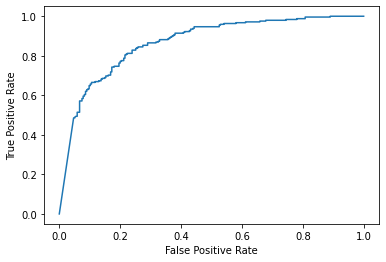


AUC value: 0.8675390156062425


In [12]:
compute_statistics(y_test, test_elements, predictions)

**LOADING THE SUBJECTIVITY/OBJECTIVITY DATASET**

In [13]:
#Save all the subjective and objective sentences in two different tables

indexes = []
for i in range(0, 5000):
    indexes.append(i)

subjectivity_table = pd.DataFrame(index=indexes, columns=["Sentence", "Typology"])
for i in range(0, 5000):
    sentence = ' '.join(subjectivity.sents('quote.tok.gt9.5000')[i])
    subjectivity_table.loc[i, "Sentence"] = sentence
    subjectivity_table.loc[i, "Typology"] = "Subjective"
    
display(subjectivity_table.head())

objectivity_table = pd.DataFrame(index=indexes, columns=["Sentence", "Typology"])
for i in range(0, 5000):
    sentence = ' '.join(subjectivity.sents('plot.tok.gt9.5000')[i])
    objectivity_table.loc[i, "Sentence"] = sentence
    objectivity_table.loc[i, "Typology"] = "Objective"

display(objectivity_table.head())

,Sentence,Typology
0,"smart and alert , thirteen conversations about...",Subjective
1,"color , musical bounce and warm seas lapping o...",Subjective
2,it is not a mass-market entertainment but an u...,Subjective
3,a light-hearted french film about the spiritua...,Subjective
4,my wife is an actress has its moments in looki...,Subjective


,Sentence,Typology
0,the movie begins in the past where a young boy...,Objective
1,emerging from the human psyche and showing cha...,Objective
2,spurning her mother's insistence that she get ...,Objective
3,amitabh can't believe the board of directors a...,Objective
4,"she , among others excentricities , talks to a...",Objective


**SUBJECTIVITY/OBJECTIVITY CLASSIFICATION**

In [14]:
subjective_objective_sentences = [] #array that contains both subjective and objective sentences
subjective_objective_target_vector = []

for i in range(0, 5000):
    subjective_objective_sentences.append(subjectivity_table.loc[i]["Sentence"])
    subjective_objective_target_vector.append(subjectivity_table.loc[i]["Typology"])
    
for i in range(0, 5000):
    subjective_objective_sentences.append(objectivity_table.loc[i]["Sentence"])
    subjective_objective_target_vector.append(objectivity_table.loc[i]["Typology"])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(subjective_objective_sentences, subjective_objective_target_vector, random_state=1)

vectorizer = TfidfVectorizer() 
classifier = MultinomialNB()

train_elements = vectorizer.fit_transform(X_train).toarray()
test_elements = vectorizer.transform(X_test).toarray()

classifier.fit(train_elements, y_train)

predictions = classifier.predict(test_elements)
report = classification_report(y_test, predictions, target_names=["Subjective", "Objective"])
print(report)

              precision    recall  f1-score   support

  Subjective       0.92      0.92      0.92      1229
   Objective       0.92      0.92      0.92      1271

    accuracy                           0.92      2500
   macro avg       0.92      0.92      0.92      2500
weighted avg       0.92      0.92      0.92      2500



,TN,FP,FN,TP
1,1126,103,100,1171


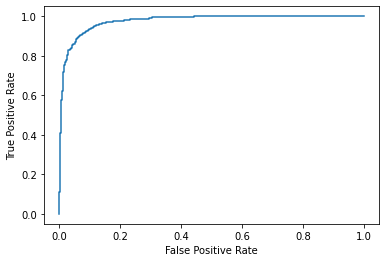


AUC value: 0.9759228044523286


In [16]:
#I wrote the function again because the pos_labels in this case are different

#printing the confusion matrix
confusion_matrix = pd.DataFrame(index=[1], columns=["TN", "FP", "FN", "TP"])
cf_matrix = metrics.confusion_matrix(y_test, predictions)
confusion_matrix.loc[1, "TN"] = cf_matrix[0][0]
confusion_matrix.loc[1, "FP"] = cf_matrix[0][1]
confusion_matrix.loc[1, "FN"] = cf_matrix[1][0]
confusion_matrix.loc[1, "TP"] = cf_matrix[1][1]
display(confusion_matrix)

#printing the roc curve
y_pred_prob = classifier.predict_proba(test_elements)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob, pos_label='Subjective')
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#printing the AUC
auc = metrics.roc_auc_score(y_test, y_pred_prob)
print("\nAUC value: {}".format(auc))

**POLARITY CLASSIFICATION WITH A MULTINOMIAL NAIVE BAYES**

Eliminating the objective sentences using the model for subjectivity/objectivity detection

In [17]:
#Read each sentence of each review and do subjectivity detection. Then eliminate the objective phrases

modified_negative_review = [] #contains only the subjective parts of each review 
for review in negative_reviews:
    current_review = [] #we build the modified review in here
    for sentence in review:
        sentence = [' '.join(sentence)]
        vectorized_sentence = vectorizer.transform(sentence)
        sentence_prediction = classifier.predict(vectorized_sentence)
        if str(sentence_prediction[0]) == 'Subjective':
            current_review.append(sentence[0])
    
    modified_negative_review.append(current_review)
    
modified_positive_review = [] #contains only the subjective parts of each review
for review in positive_reviews:
    current_review = [] #we build the modified review in here
    for sentence in review:
        sentence = [' '.join(sentence)]
        vectorized_sentence = vectorizer.transform(sentence)
        sentence_prediction = classifier.predict(vectorized_sentence)
        if str(sentence_prediction[0]) == 'Subjective':
            current_review.append(sentence[0])
    
    modified_positive_review.append(current_review)

#put in the correct format both datasets
subjective_negative_reviews = []
for mod_rev in modified_negative_review:
    subjective_negative_reviews.append('\n'.join(mod_rev))
    
subjective_positive_reviews = []
for mod_rev in modified_positive_review:
    subjective_positive_reviews.append('\n'.join(mod_rev))
    
subjective_reviews = subjective_negative_reviews + subjective_positive_reviews

Compute a second baseline by taking into consideration only the subjective sentences of the reviews

In [18]:
X_train, X_test, y_train, y_test = train_test_split(subjective_reviews, target_vector)

vectorizer = CountVectorizer()
classifier = MultinomialNB() 

train_elements = vectorizer.fit_transform(X_train).toarray()
test_elements = vectorizer.transform(X_test).toarray()

classifier.fit(train_elements, y_train)

predictions = classifier.predict(test_elements)
report = classification_report(y_test, predictions, target_names=["neg", "pos"])
print(report)

              precision    recall  f1-score   support

         neg       0.86      0.82      0.84       271
         pos       0.79      0.84      0.82       229

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



,TN,FP,FN,TP
1,221,50,36,193


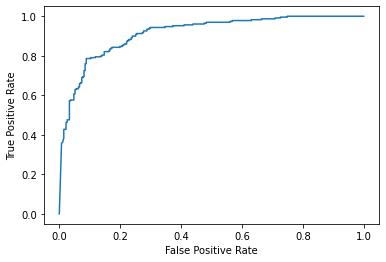


AUC value: 0.9140978746032002


In [19]:
compute_statistics(y_test, test_elements, predictions)

**PRE-PROCESSING STEPS AND FEATURE SELECTION**

In the following section, we will introduce many different types of pre-processing steps that will make our dataset more robust. This should help us getting higher accuracy when testing

APPLY TOKENIZATION

In [20]:
def apply_tokenization(reviews_dataset):
    """
    Divide the text into tokens
    @reviews_dataset: dataset
    """
    tokenized_reviews = []
    for review in reviews_dataset:
        tokenized_reviews.append(word_tokenize(review))
    
    return tokenized_reviews

CORRECTING WORDS LIKE: "COOOOOOOOOLLLLL", "LOOOOOOOOOOOOOOOOOT" ETC...

In [21]:
def count_consecutive_characters(word, begin, end, count):
    """
    Counts the consecutive occurences of the same character
    @word: string representing the word we are working with
    @begin: position in the word from where we start analyzing it
    @end: total length of the word
    @count: total consecutive occurences of a character
    """
    if begin == end:
        return count
    for i in range(begin, end):
        if word[i-1] == word[i]:
            return count_consecutive_characters(word, begin+1, end, count+1)
        else:
            return count

def csv_iter(word, begin, end, new_word):
    """
    Recursive call
    """
    if (end - begin) >= 3:
        if word[begin] == word[begin+1] and word[begin] == word[begin+2]: #at least 3 consecutive
            consec_char = count_consecutive_characters(word, begin+1, end, 1)
            new_word = new_word + word[begin]
            if begin+consec_char < end:
                return csv_iter(word, begin+consec_char, end, new_word)
            else:
                return new_word
        else:
            new_word = new_word+word[begin]
            return csv_iter(word, begin+1, end, new_word)
    else:
        return new_word+word[begin:end]
        

def check_sequence_vocals(word):
    """
    Remove the vowels repeated in sequence at least three times (i.e. cooooool and cool)
    @word: string representing the word we are working with
    return correct word
    """
    
    return csv_iter(word, 0, len(word), '')

In [22]:
def remove_repetitions(review_dataset):
    #eliminate huge sequences like coooooooool
    removed_reviews = []
    for review in review_dataset:
        current_review = []
        for i in range(0, len(review)): 
            current_review.append(check_sequence_vocals(review[i]))
        
        removed_reviews.append(current_review)
    
    return removed_reviews

APPLY POS TAGS FOR EACH TOKEN

In [23]:
def apply_pos(reviews_dataset):
    """
    Apply pos-tagging for each token
    @reviews_dataset: dataset
    """
    pos_reviews = []
    for review in reviews_dataset:
        pos_reviews.append(nltk.pos_tag(review, tagset='universal')) #the whole review is (word, pos)
        
    return pos_reviews

MODIFY VERBS SINTAX

In [24]:
def modify_verb_sintax(reviews_dataset):
    """
    Write in the correct way the verbs and change its pos-tag into the correct one
    @reviews_dataset: dataset
    """
    verb_review = []
    for review in reviews_dataset:
        current_review = []
        for i in range(0, len(review)): 
            if review[i][0] != '[' and review[i][0] != ']' and review[i][0] != '/' and review[i][0] !='\'': #removal of useless symbols
                if review[i][0] == 'lot':
                    current_review.append((review[i][0], 'ADV')) #lot is considered always as a noun instead of an adverb, so we change it by hand
                elif review[i][0] == 'i':
                    current_review.append((review[i][0], 'PRON')) #"i" is considered sometimes as a NOUN or VERB since it's misspelled. we change this by hand
                elif review[i][0] == 've':
                    current_review.append(('have', 'VERB'))
                elif review[i][0] == 's':
                    current_review.append(('is', 'VERB'))
                elif review[i][0] == 'doesn':
                    current_review.append(('doesn\'t', 'VERB'))
                elif review[i][0] == 'didn':
                    current_review.append(('didn\'t', 'VERB'))
                elif review[i][0] == 'hasn':
                    current_review.append(('hasn\'t', 'VERB'))
                elif review[i][0] == 'aren':
                    current_review.append(('aren\'t', 'VERB'))
                elif review[i][0] == 'isn':
                    current_review.append(('isn\'t', 'VERB'))
                elif review[i][0] == 'don':
                    current_review.append(('don\'t', 'VERB'))
                elif review[i][0] == 't': #we don't save this
                    continue
                else:
                    current_review.append((review[i][0], review[i][1]))
        verb_review.append(current_review)
    
    return verb_review

APPLY TRANSFORMATION IN ORDER TO MATCH THE FORMAT REQUESTED BY THE LEMMATIZER

In [25]:
def apply_transformation(reviews_dataset):
    #i have to transform the pos into the elements requested by the lemmatizer (only the 4 ones listed below)
    tok_pos_review = []
    for review in reviews_dataset:
        current_review = []
        for word, pos in review:
            match pos:
                case "NOUN":
                    current_review.append((word, "n"))
                case "VERB":
                    current_review.append((word, "v"))
                case "ADJ":
                    current_review.append((word, "a"))
                case "ADV":
                    current_review.append((word, "r"))
                case _:
                    current_review.append((word, pos))
        tok_pos_review.append(current_review)
    
    return tok_pos_review

APPLY LEMMATIZATION

In [26]:
def apply_lemmatization(reviews_dataset):
    lemmatizer = WordNetLemmatizer()
    lemmatized_reviews = []
    for review in reviews_dataset:
        lemmatized_review = []
        for t, pos in review:
            if pos == "n" or pos == "v" or pos == "a" or pos == "r":
                lemmatized_review.append(lemmatizer.lemmatize(t, pos=pos))
            else:
                lemmatized_review.append(t)

        lemmatized_reviews.append(lemmatized_review)
        
    return lemmatized_reviews

NEGATION HANDLING

In [27]:
def apply_negation(reviews_dataset):
    negated_reviews = []
    for review in reviews_dataset:
        negated_reviews.append(mark_negation(review))
        
    return negated_reviews

OMITTING PUNCTUATION

In [28]:
def omitt_punctuation(reviews_dataset):
    """
    Remove the punctuation and useless symbols from the corpus
    @reviews_dataset: dataset
    """
    punct_reviews = []
    for review in reviews_dataset:
        current_review = []
        for word in review:
            if word != '.' and word != ',' and word != '``' and word != '!' and word != '?' and word != '(' and word != ')' and word != '-' and word != ':':
                current_review.append(word)
        punct_reviews.append(current_review)
    
    return punct_reviews

APPLYING ALL THE CHANGES

In [29]:
def apply_all_changes(mod_subjective_reviews):
    #with all of them i get 89 accuracy%
    #with tokenization, pos, modification of verbs, remove repetitions and omitt punctuation i get 91%
    mod_subjective_reviews = apply_tokenization(mod_subjective_reviews)
    mod_subjective_reviews = remove_repetitions(mod_subjective_reviews)
    mod_subjective_reviews = apply_pos(mod_subjective_reviews)
    mod_subjective_reviews = modify_verb_sintax(mod_subjective_reviews)
    
    intermediate_transformation = [] #i need to get rid of the pos tag for the next pre-processing steps
    for review in mod_subjective_reviews:
        c_review = []
        for word, pos in review:
            c_review.append(word)
        intermediate_transformation.append(c_review)
    
    #mod_subjective_reviews = apply_transformation(mod_subjective_reviews)
    #mod_subjective_reviews = apply_lemmatization(mod_subjective_reviews)
    #mod_subjective_reviews = apply_negation(mod_subjective_reviews) #lose 1%
    mod_subjective_reviews = omitt_punctuation(intermediate_transformation)
    
    return mod_subjective_reviews

In [30]:
mod_subjective_reviews = apply_all_changes(subjective_reviews)

In [31]:
#Put in the correct format the dataset (get rid of the tokenization)

final_review_dataset = []
for review in mod_subjective_reviews:
    final_review_dataset.append(' '.join(review))

COMPUTING ACCURACY OF THE MODEL

In [32]:
X_train, X_test, y_train, y_test = train_test_split(final_review_dataset, target_vector, random_state=7)

vectorizer = CountVectorizer(ngram_range=(1,3), min_df=2, max_df=450,  lowercase=True)
classifier = MultinomialNB() 

train_elements = vectorizer.fit_transform(X_train).toarray()
test_elements = vectorizer.transform(X_test).toarray()

classifier.fit(train_elements, y_train)

predictions = classifier.predict(test_elements)
report = classification_report(y_test, predictions, target_names=["neg", "pos"])
print(report)

              precision    recall  f1-score   support

         neg       0.91      0.90      0.90       248
         pos       0.90      0.91      0.91       252

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500



,TN,FP,FN,TP
1,223,25,22,230


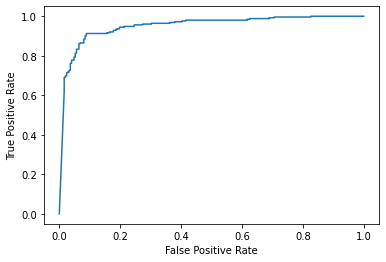


AUC value: 0.951244879672299


In [33]:
compute_statistics(y_test, test_elements, predictions)

LOWER THE NUMBER OF FEATURES SINCE WE HAVE A LOT OF THEM. WE DO FEATURE OPTIMIZATION USING CHI2

In [34]:
X_train, X_test, y_train, y_test = train_test_split(final_review_dataset, target_vector, random_state=7)

vectorizer = CountVectorizer(ngram_range=(1,3), min_df=2, max_df=450, lowercase=True)
train_elements = vectorizer.fit_transform(X_train).toarray()
test_elements = vectorizer.transform(X_test).toarray()
print("Number of features: {}\n".format(train_elements.shape))

#feature optimization with chi2
constant_feature_selector = SelectKBest(score_func=chi2, k=20000) #from 20000 features onwards we get 91%, from 5000 to 19999 we get 90% accuracy
constant_feature_selector.fit(train_elements, y_train)

train_set = constant_feature_selector.transform(train_elements)
test_set = constant_feature_selector.transform(test_elements)
print("Number of features after optimization: {}\n".format(train_set.shape))

classifier = MultinomialNB()
classifier.fit(train_set, y_train) #train the classifier

predictions = classifier.predict(test_set)
report = classification_report(y_test, predictions, target_names=["neg", "pos"])
print(report)

Number of features: (1500, 112792)

Number of features after optimization: (1500, 20000)

              precision    recall  f1-score   support

         neg       0.90      0.92      0.91       248
         pos       0.91      0.90      0.91       252

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500



**POLARITY CLASSIFICATION WITH A BERT MODEL**

In [36]:
binary_target_vector = []
for el in target_vector: #0 for neg, 1 for pos
    if el == 'neg':
        binary_target_vector.append(0)
    else:
        binary_target_vector.append(1)

In [36]:
tokenizer_transformer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
transformer_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

In [37]:
def sentiment_score(portion_of_review):
    """
    Compute the sentiment score of a portion of text
    @portion_of_review: sentences of a review
    """
    tokens = tokenizer_transformer.encode(portion_of_review, return_tensors='pt', max_length=512, truncation=True)
    result = transformer_model(tokens)
    return (int(torch.argmax(result.logits))+1)

def compute_sentiment_review(review):
    """
    Compute the sentiment score of a review
    @review: movie review
    """
    len_review = len(review)
    num_of_splits = int(len_review/512)
    total_score = 0
    
    for i in range(0, num_of_splits):
        review_split = review[512*i:512*(i+1)]
        individual_score = sentiment_score(review_split)
        total_score += individual_score
        
    if (len_review % 512) > 0: #there is still some text left
        review_split = review[512*num_of_splits:]
        individual_score = sentiment_score(review_split)
        total_score += individual_score
        num_of_splits += 1
    
    average_score = (total_score/num_of_splits)
    
    if average_score > 2:
        return "pos"
    else:
        return "neg"

In [38]:
bert_predictions = []
i = 0
for review in final_review_dataset:
    print(i)
    i += 1
    bert_predictions.append(compute_sentiment_review(review))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999


In [39]:
report = classification_report(target_vector, bert_predictions, target_names=["neg", "pos"])
print(report)

              precision    recall  f1-score   support

         neg       0.82      0.92      0.86      1000
         pos       0.91      0.80      0.85      1000

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



**FINE-TUNING A DIFFERENT BERT MODEL**

In [37]:
X_train, X_test, y_train, y_test = train_test_split(final_review_dataset, binary_target_vector, random_state=7)

In [38]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
#can be up to 512 for BERT
max_length = 512
batch_size = 6

In [40]:
def convert_example_to_feature(review):
    """
    Tokenize the review and format it in the correct way
    """
    return tokenizer.encode_plus(review,
                add_special_tokens = True, # add [CLS], [SEP]
                max_length = max_length, # max length of the text that can go to BERT
                pad_to_max_length = True, # add [PAD] tokens
                return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

In [41]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    """
    Format the input in the way that is requested by the BERT model
    """
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
    }, label

In [42]:
def encode_examples(ds, limit=-1):
    # prepare list, so that we can build up final TensorFlow dataset from slices.
    input_ids_list = []
    token_type_ids_list = []
    attention_mask_list = []
    label_list = []
    if (limit > 0):
        ds = ds.take(limit)
    for review, label in ds:
        bert_input = convert_example_to_feature(review)
        input_ids_list.append(bert_input['input_ids'])
        token_type_ids_list.append(bert_input['token_type_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [43]:
training = []
testing = []

for i in range(len(X_train)):
    training.append((X_train[i], y_train[i]))

for i in range(len(X_test)):
    testing.append((X_test[i], y_test[i]))
    
# train dataset
ds_train_encoded = encode_examples(training).shuffle(10000).batch(batch_size)
# test dataset
ds_test_encoded = encode_examples(testing).batch(batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\matte\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\tokenization_utils_base.py:2285: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



In [44]:
# recommended learning rate for Adam 5e-5, 3e-5, 2e-5
learning_rate = 2e-5
# we will do just 2 epoch, if more it will overfit
number_of_epochs = 2

In [45]:
# choosing Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [46]:
bert_history = model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded) #values ranges from 89% to 92%. Depends on how the BERT model is initialized

Epoch 1/2
250/250 [==============================] - 4726s 19s/step - loss: 0.6385 - accuracy: 0.6133 - val_loss: 0.2896 - val_accuracy: 0.8840
Epoch 2/2
250/250 [==============================] - 4616s 18s/step - loss: 0.2536 - accuracy: 0.9047 - val_loss: 0.2264 - val_accuracy: 0.9060
